## Modeling

###  Multiple Regression model

**Business question:** Build a predictive model to predict the Taxi Fair price prior to the trip

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import date
from datetime import timedelta

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [5]:
df = pd.read_csv('dataafterEDA.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [7]:
# Convert data columns to datetime
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])

#create a column trip_duration
df['trip_duration'] = (df['tpep_dropoff_datetime']-df['tpep_pickup_datetime'])/np.timedelta64(1,'m')

### Outliers detection and imputing

The most important features to be used to fit the model are tri_distance, fare_amount, duration. So we will resolve the outliers problem for these variables.

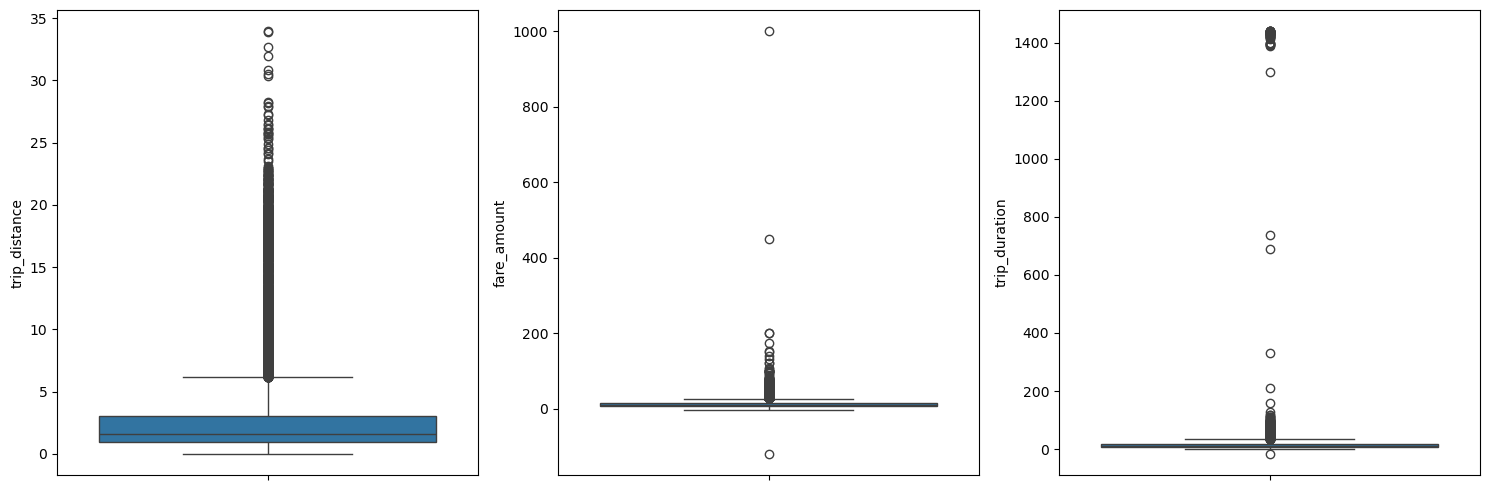

In [8]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
sns.boxplot(df['trip_distance'],ax=axes[0])
sns.boxplot(df['fare_amount'],ax=axes[1])
sns.boxplot(df['trip_duration'],ax=axes[2])
plt.tight_layout()

1. All 3 have outliers
2. the outlier values is in trip_distance seem consistent with the actual between southern tip of Staten Island to the northern end of Manhattan. so it is reasonable to not alter them.
3. the fare_amount and duration seem to have problematic outliers and have to either impute or remove them.

In [9]:
# imputing outliers
# trip_distance
sorted(set(df['trip_distance']))[:10],sum(df['trip_distance']==0)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09], 148)

148 out of ~23,000 rides is relatively insignificant , so imputing them or leaving them as it is is not going to effect the model much. trip_distance is left untounched.

In [10]:
# fare_amount
df['fare_amount'].describe()

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

1. The max value is very much greater than the 75th percentile there for assign either Q3 + (6 * IQR) value to the values greater than Q3 + (6 * IQR), as 75th seems not to justify the higher values.
2. For lower values which are negative assign them value of 0.

In [11]:
def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold
        print(df[col].describe())
        print()

In [12]:
# Impute values less than $0 with 0
df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0
df['fare_amount'].min()
#  impute higher values
outlier_imputer(['fare_amount'], 6)

fare_amount
q3: 14.5
upper_threshold: 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64



In [13]:
# imputing trip duration outliers
df['trip_duration'].describe()

count    22699.000000
mean        17.013777
std         61.996482
min        -16.983333
25%          6.650000
50%         11.183333
75%         18.383333
max       1439.550000
Name: trip_duration, dtype: float64

1. Impute all negative durations with 0 as there should not be -ve values.
2. impute the duration values higher than Q3 + ( 6 * IQR ) with Q3 + ( 6 * IQR ), as we can observe some extreme outliers .

In [15]:
# Impute a 0 for any negative values
df.loc[df['trip_duration'] < 0, 'trip_duration'] = 0
df['trip_duration'].min()
# Impute the high outliers
outlier_imputer(['trip_duration'], 6)

trip_duration
q3: 18.383333333333333
upper_threshold: 88.78333333333333
count    22699.000000
mean        14.460555
std         11.947043
min          0.000000
25%          6.650000
50%         11.183333
75%         18.383333
max         88.783333
Name: trip_duration, dtype: float64



### Feature Engineering

Create a feature called mean_distance that calculates the mean of the trip_distance for all unique PULocationID, DOLocationID pairs. this way we can dropoff the PULocationID, DOLocationID columns and make use of them in the model.

1. mean_distance

In [16]:
# identify all the unique trips with pickup_dropoff string
df['pickup_dropoff']= df['PULocationID'].astype(str)+ ' ' + df['DOLocationID'].astype(str)
df['pickup_dropoff'].head(2)

0    100 231
1     186 43
Name: pickup_dropoff, dtype: object

In [17]:
# calculating mean_distance
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['trip_distance']]
grouped[:5]

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000
100 100,0.253333
100 107,1.180000


In [19]:
# convert it into dictionary so that you can use it to map with the df['pickup_dropoff'] column
grouped_dict = grouped.to_dict()
grouped_dict = grouped_dict['trip_distance']
df['mean_distance'] = df['pickup_dropoff']
df['mean_distance'] = df['mean_distance'].map(grouped_dict)

2. mean_duration : mean of trip duration between unique pair of pickup and dropoff points

In [21]:
# similarly creating mean_duration for all pickup and dropoff pairs
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['trip_duration']]

grouped_dict = grouped.to_dict()
grouped_dict = grouped_dict['trip_duration']

df['mean_duration'] = df['pickup_dropoff']
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

3. rush_hour : to depicts the time of the day
   
Define rush hour as:

    1. Any weekday (not Saturday or Sunday) AND
    2. Either from 06:00–10:00 or from 16:00–20:00

In [23]:
# Create 'day' col
df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()

# Create 'month' col
df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower
df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour
df.loc[df['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0

In [24]:
def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

In [25]:
df.loc[(df.day != 'saturday') & (df.day != 'sunday'), 'rush_hour'] = df.apply(rush_hourizer, axis=1)
df.head()

/var/folders/mh/p31c9s4j7x96gcg6jjhwgmd00000gn/T/ipykernel_54383/75387958.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0 1 1 ... 1 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[(df.day != 'saturday') & (df.day != 'sunday'), 'rush_hour'] = df.apply(rush_hourizer, axis=1)


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tolls_amount,improvement_surcharge,total_amount,month,day,trip_duration,pickup_dropoff,mean_distance,mean_duration,rush_hour
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,0.0,0.3,16.56,<bound method StringMethods.lower of <pandas.c...,saturday,14.066667,100 231,3.521667,22.847222,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,0.0,0.3,20.80,<bound method StringMethods.lower of <pandas.c...,tuesday,26.500000,186 43,3.108889,24.470370,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.0,0.3,8.75,<bound method StringMethods.lower of <pandas.c...,friday,7.200000,262 236,0.881429,7.250000,1
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,0.0,0.3,27.69,<bound method StringMethods.lower of <pandas.c...,sunday,30.250000,188 97,3.700000,30.250000,0
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,...,0.0,0.3,17.80,<bound method StringMethods.lower of <pandas.c...,saturday,16.716667,4 112,4.435000,14.616667,0


### Plot some visualisations
plot some visualisation with new variables against fare_amount

<Axes: xlabel='mean_duration', ylabel='fare_amount'>

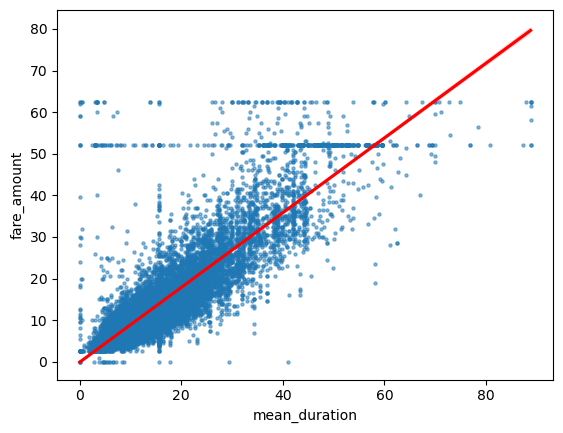

In [26]:
sns.regplot(x=df['mean_duration'],y=df['fare_amount'],scatter_kws={'alpha':0.5,'s':5},line_kws={'color':'red'})

1. The mean_duration variable correlates with the target variable.
2. Two horizontal lines at \\$52 and  \\$62.50
3. One of the lines represents. 62 dollars and 50 cents is the maximum that was imputed for outliers, so all former outliers will now have fare amounts of $62.50.


In [27]:
# horizontal line at $52
df[df['fare_amount'] > 50]['fare_amount'].value_counts().head()

fare_amount
52.0    514
62.5     84
59.0      9
50.5      9
57.5      8
Name: count, dtype: int64

By checking the PULocationID , DOLocationID at these points show that they have RatecodeID value 2 which means the trips are either to or from the JFK area which is an airport and there was indeed a flat fare for taxi trips between JFK airport (in Queens) and Manhattan on the internet.

### feature selection

In [36]:
df2 = df.copy()

df2 = df2.drop(['Unnamed: 0','tpep_dropoff_datetime', 'tpep_pickup_datetime',
               'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID','store_and_fwd_flag',
               'payment_type', 'tip_amount', 'tolls_amount','improvement_surcharge','mta_tax','extra',
               'total_amount', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'trip_duration',
               'pickup_dropoff', 'day', 'month'
               ], axis=1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22699 non-null  int64  
 1   passenger_count  22699 non-null  int64  
 2   fare_amount      22699 non-null  float64
 3   mean_distance    22699 non-null  float64
 4   mean_duration    22699 non-null  float64
 5   rush_hour        22699 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 1.0 MB


### Correlation

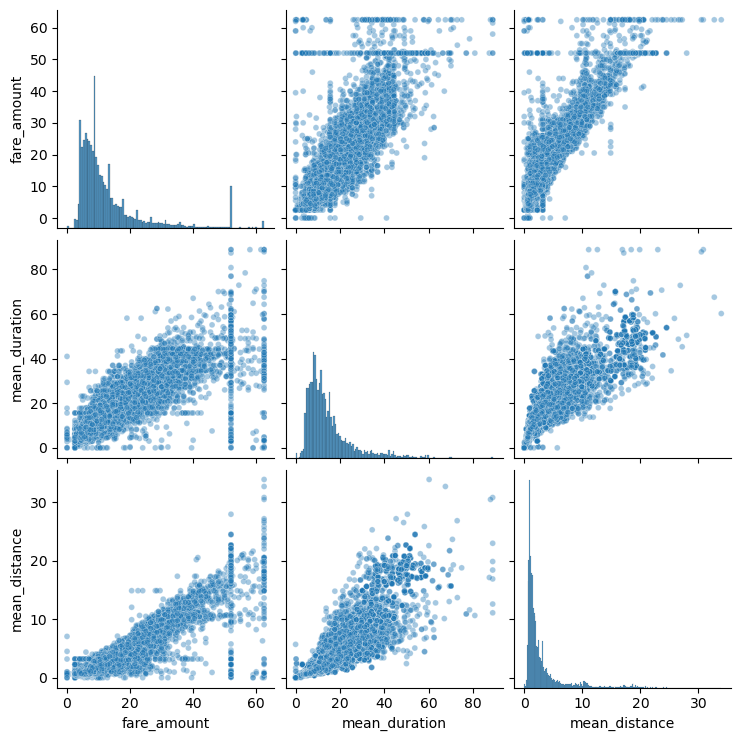

In [37]:
sns.pairplot(df2[['fare_amount', 'mean_duration', 'mean_distance']],
             plot_kws={'alpha':0.4, 'size':5},
             );

These variables all show linear correlation with each other. Investigate this further.

<Axes: >

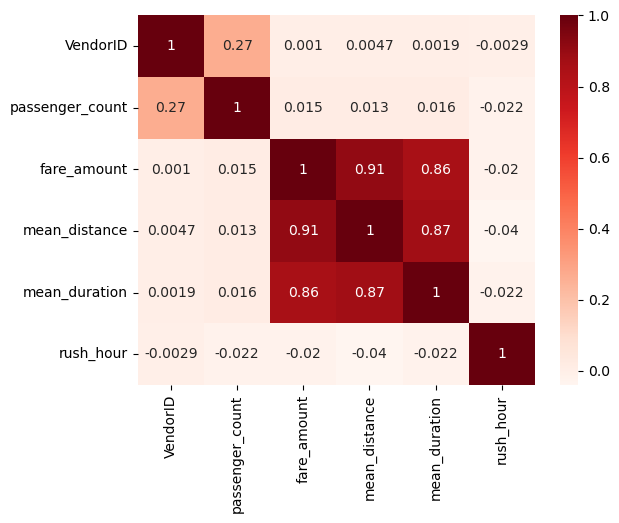

In [38]:
sns.heatmap(df2.corr(method='pearson'), annot=True, cmap='Reds')

There is a high correlation between mean_distance and mean_duration. Including two highly correlated predictors into the model can be bad for drawing statistical inferences from them but if accurate prediction is the main focus of the model then correlated predictors can be present in the model.

### train_test_split

In [39]:
X = df2.drop(columns=['fare_amount'])
y = df2[['fare_amount']]
X.head()

,VendorID,passenger_count,mean_distance,mean_duration,rush_hour
0,2,6,3.521667,22.847222,0
1,1,1,3.108889,24.470370,0
2,1,1,0.881429,7.250000,1
3,2,1,3.700000,30.250000,0
4,2,1,4.435000,14.616667,0


In [40]:
# Convert VendorID to string
X['VendorID'] = X['VendorID'].astype(str)

# Get dummies
X = pd.get_dummies(X, drop_first=True)
X.head()

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,6,3.521667,22.847222,0,True
1,1,3.108889,24.470370,0,False
2,1,0.881429,7.250000,1,False
3,1,3.700000,30.250000,0,True
4,1,4.435000,14.616667,0,True


In [41]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Standardize the X variables

scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_train_scaled

array([[-0.50301524,  0.8694684 ,  0.17616665, -0.64893329,  0.89286563],
       [-0.50301524, -0.60011281, -0.69829589,  1.54099045,  0.89286563],
       [ 0.27331093, -0.47829156, -0.57301906, -0.64893329, -1.11998936],
       ...,
       [-0.50301524, -0.45121122, -0.6788917 , -0.64893329, -1.11998936],
       [-0.50301524, -0.58944763, -0.85743597,  1.54099045, -1.11998936],
       [ 1.82596329,  0.83673851,  1.13212101, -0.64893329,  0.89286563]])

In [42]:
# Fit model to the training data

lr =LinearRegression()
lr.fit(x_train_scaled,y_train)

LinearRegression()

In [48]:
## Coefficients
coefficients = pd.DataFrame(lr.coef_, columns=X.columns)
coefficients

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,0.030825,7.133867,2.812115,0.110233,-0.054373


In [43]:
from sklearn.metrics import r2_score

# Evaluate the model performance on the training data

r_sq = lr.score(x_train_scaled,y_train)
y_pred1 = lr.predict(x_train_scaled)
r2_score = r2_score(y_train,y_pred1)
mae = mean_absolute_error(y_train,y_pred1)
mse = mean_squared_error(y_train,y_pred1)
rmse = np.sqrt(mse)
print(r_sq,r2_score,mae,mse,rmse)

0.8398434585044773 0.8398434585044773 2.1866664167754144 17.88973296349268 4.229625629236313


In [45]:
from sklearn.metrics import r2_score
# Scale the X_test data

x_test_scaled = scaler.transform(x_test)

# Evaluate the model performance on the testing data

r_sq = lr.score(x_test_scaled,y_test)
y_pred2 = lr.predict(x_test_scaled)
r = r2_score(y_test,y_pred2)
mae = mean_absolute_error(y_test,y_pred2)
mse = mean_squared_error(y_test,y_pred2)
rmse = np.sqrt(mse)
print(r_sq,r,mae,mse,rmse)

0.8682583641795454 0.8682583641795454 2.1336549840593886 14.326454156998954 3.7850302716093243


### checking model assumptions

1. Linearity: Each predictor variable (Xi) is linearly related to the outcome variable (Y).
2. Normality: The errors are normally distributed.*
3. Independent Observations: Each observation in the dataset is independent.
4. Homoscedasticity: The variance of the errors is constant or similar across the model.
5. Multicollinearity : The features should not be multicollinear inorder to make inferences about their effect in target variable.

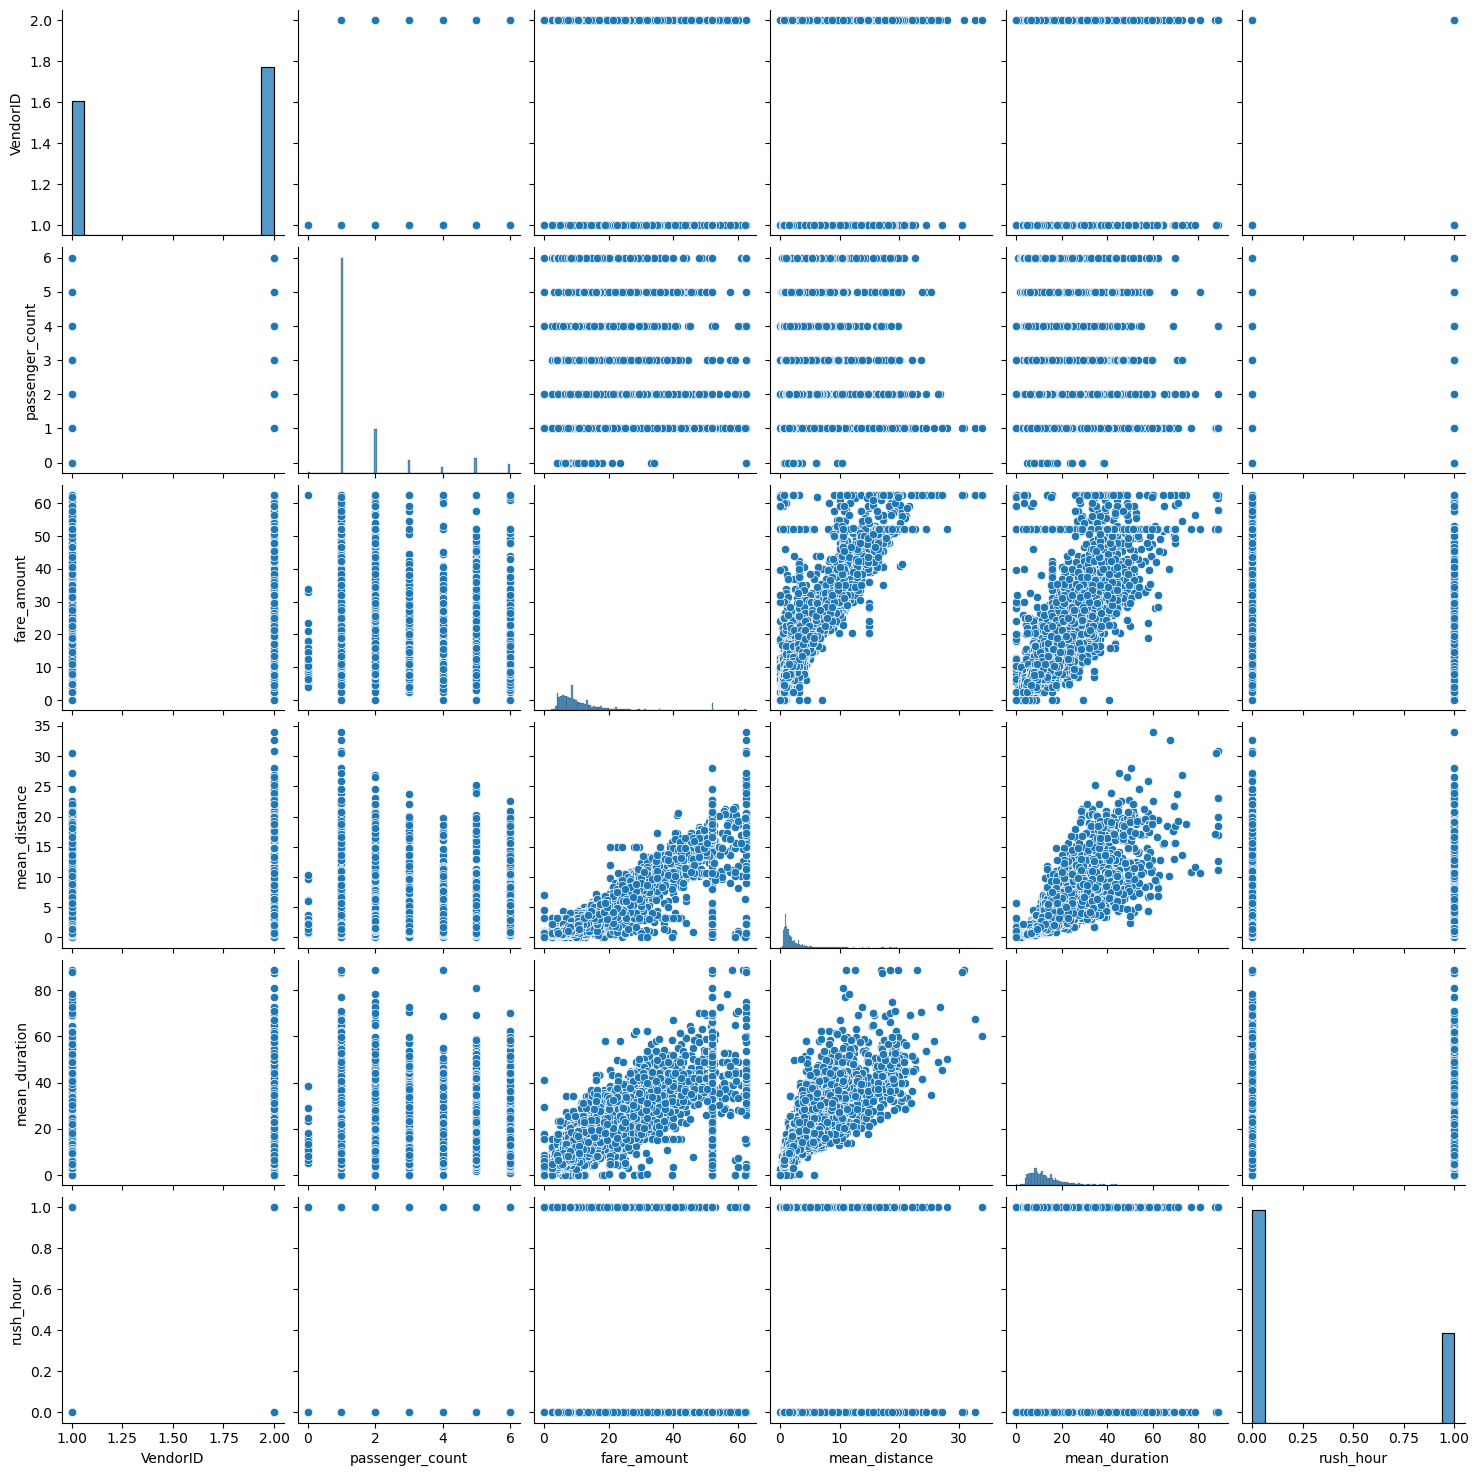

In [49]:
# from the coefficients of features you can see the linearity between the feature and target variable for features wiht greater coefficients
sns.pairplot(df2)

In [46]:
# Normality of errors
res = pd.DataFrame(data={'actual': y_test['fare_amount'],
                             'predicted': y_pred2.ravel()})
res['residual'] = res['actual'] - res['predicted']
res.head()

,actual,predicted,residual
5818,14.0,12.356503,1.643497
18134,28.0,16.314595,11.685405
4655,5.5,6.726789,-1.226789
7378,15.5,16.227206,-0.727206
13914,9.5,10.536408,-1.036408


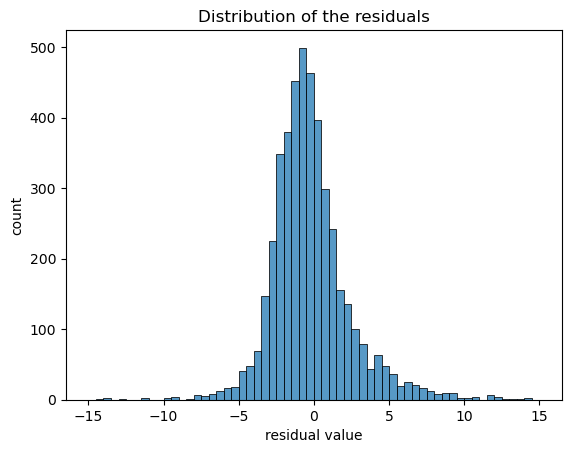

In [50]:
sns.histplot(res['residual'], bins=np.arange(-15,15.5,0.5))
plt.title('Distribution of the residuals')
plt.xlabel('residual value')
plt.ylabel('count');

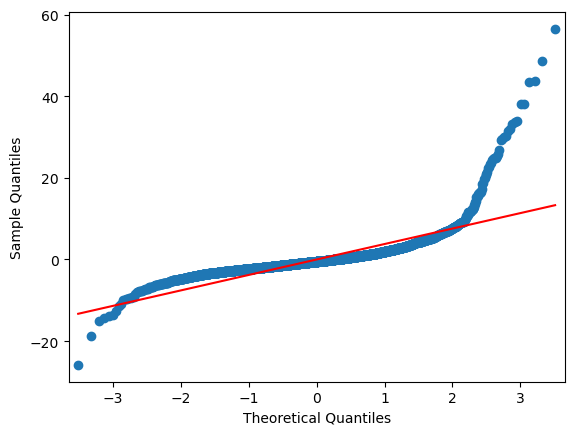

In [58]:
sm.qqplot(res['residual'],line='s')
plt.show()

From above plots we can say that the errors are aproximately normally distributed

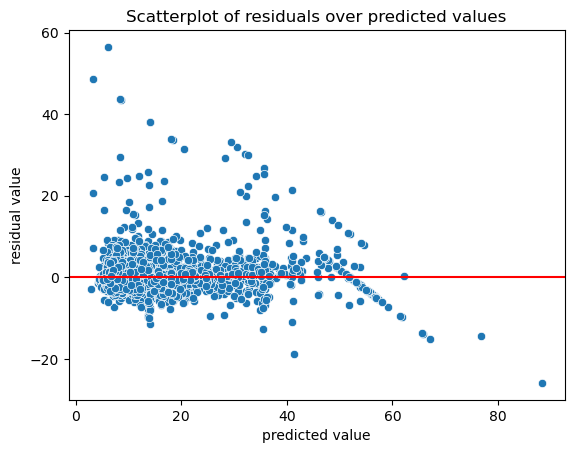

In [59]:
# Homeskedasticity
# Create a scatterplot of `residuals` over `predicted`

sns.scatterplot(x='predicted', y='residual', data=res)
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted values')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.show()

the variance of the errors is constant across the model . The lines that are observed are due to the imputed values.

For multicollinearity, we have allowed the features to be correlated to get more accurate prediction due to which the model coefficients obtained have higher uncertainty associated with it.


In [60]:
coefficients

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2
0,0.030825,7.133867,2.812115,0.110233,-0.054373


1. The coefficients reveal that mean_distance was the feature with the greatest weight in the model's final prediction.
2. the data used to train the model was standardized with StandardScaler(). As such, the units are no longer miles.
3. The correct interpretation of this coefficient is: controlling for other variables, for every +1 change in standard deviation, the fare amount increases by a mean of $7.13.

In [61]:
# 1. Calculate SD of `mean_distance` in X_train data
print(x_train['mean_distance'].std())

# 2. Divide the model coefficient by the standard deviation
print(7.133867 / x_train['mean_distance'].std())

3.574812975256415
1.9955916713344426


A more intuitive interpretation:  for every 3.57 miles traveled, the fare increased by a mean of \\$7.13. Or, reduced: for every 1 mile traveled, the fare increased by a mean of \\$2.00.

Note, however, that because some highly correlated features were not removed, the confidence interval of this assessment is wider.

Next we will explore some more business questions

In [67]:
x_train.shape,y_pred1.shape,y_train.shape

((18159, 5), (18159, 1), (18159, 1))

In [66]:
x_test.shape,y_pred2.shape,y_test.shape

((4540, 5), (4540, 1), (4540, 1))

In [89]:
r = x_train.copy()
r['fare_amount']=y_train['fare_amount']
r['predicted_fare']=y_pred1
r.shape

(18159, 7)

In [90]:
s = x_test.copy()
s['fare_amount']=y_test['fare_amount']
s['predicted_fare']=y_pred2
s.shape

(4540, 7)

In [97]:
combined_df = pd.concat([r, s])

# Sort by index
sorted_df = combined_df.sort_index()

# Display the result
sorted_df

,passenger_count,mean_distance,mean_duration,rush_hour,VendorID_2,fare_amount,predicted_fare
0,6,3.521667,22.847222,0,True,13.0,16.434245
1,1,3.108889,24.470370,0,False,16.0,16.052218
2,1,0.881429,7.250000,1,False,6.5,7.053706
3,1,3.700000,30.250000,0,True,20.5,18.731650
4,1,4.435000,14.616667,0,True,16.5,15.845642
...,...,...,...,...,...,...,...
22694,3,1.098214,8.594643,1,True,4.0,7.799138
22695,1,18.757500,59.560417,0,True,52.0,56.942034
22696,1,0.684242,6.609091,0,True,4.5,6.130896
22697,1,2.077500,16.650000,0,True,10.5,11.707049


In [99]:
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22699 entries, 0 to 22698
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  22699 non-null  int64  
 1   mean_distance    22699 non-null  float64
 2   mean_duration    22699 non-null  float64
 3   rush_hour        22699 non-null  int64  
 4   VendorID_2       22699 non-null  bool   
 5   fare_amount      22699 non-null  float64
 6   predicted_fare   22699 non-null  float64
dtypes: bool(1), float64(4), int64(2)
memory usage: 1.2 MB


In [100]:
sorted_df.to_csv('dataafterMLR.csv')